## Models fitting

In [1]:
from sklearn.linear_model import ElasticNetCV, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_hdf(r"..\input\train.h5")

In [2]:
class model_fit():
    '''
    Date: 10/12/2016
    
    ################
    Version: v.0.0.1
    Comments: Initial approximation 
    
    '''
    
    def __init__(self, model, train, columns):

        self.model   = model
        self.columns = columns
        
        y = np.array(train.y)
        X = train[columns]
        self.xMeans = X.mean(axis=0) 
        self.xStd   = X.std(axis=0)  

        X = np.array(X.fillna( self.xMeans ))
        X = (X - np.array(self.xMeans))/np.array(self.xStd)
        
        self.model.fit(X, y)
        
        return
    
    def predict(self, features):
        '''
        Prediction function
        '''
        X = features[self.columns]
        X = np.array(X.fillna( self.xMeans ))
        X = (X - np.array(self.xMeans))/np.array(self.xStd)

        return self.model.predict(X)

In [3]:
mode = 'all_columns'

if mode == 'all_columns':
    c = df.columns
    columns = [col for col in c if not col.startswith('y')]
    
if mode == 'reduce_columns':
    columns = ['technical_30', 'technical_20', 'fundamental_11', 'technical_19']
    
train   = df 
train   = train.groupby('timestamp').aggregate(np.mean) #aggregation by mean
train.y = np.cumsum(train.y) 
train.reset_index(inplace=True)

C:\Users\victor\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


MAE for model:ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)  0.00505674422474
MAE for model:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)  0.00404233848962
MAE for model:Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)  0.00413486118914


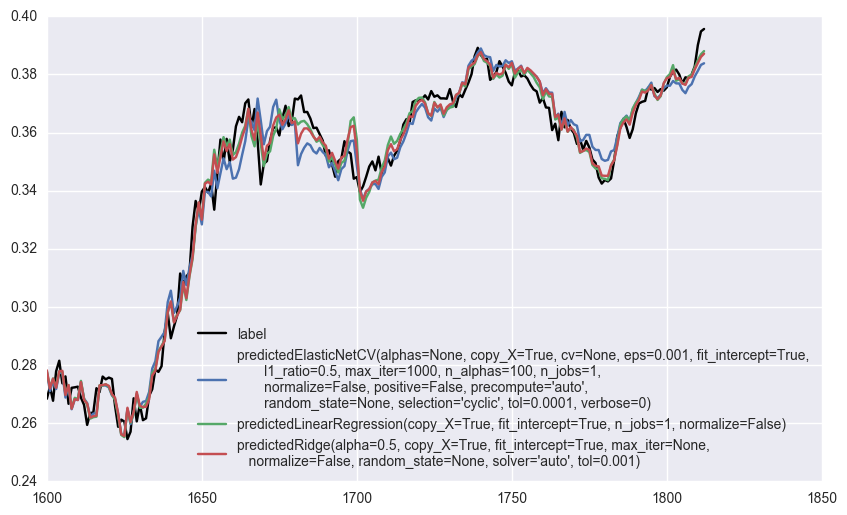

In [4]:
models = [ElasticNetCV(), LinearRegression(), Ridge (alpha = .5)]

plot_zoom = 1600
plt.figure(figsize=(10, 6))
plt.plot(train.timestamp[plot_zoom:], train.y[plot_zoom:], '-k', label='label')

for m in models: 
    model = model_fit(m, train, columns)
    y_pred = model.predict(train) # predict training set
    print 'MAE for model:' + str(m) + '  ' + str(mean_absolute_error(train.y, y_pred) )
    plt.plot(train.timestamp[plot_zoom:], y_pred[plot_zoom:], label='predicted'+str(m))
        
plt.legend(loc="lower right")      
plt.show()

# time lag variables

In [2]:
df.sort("id").id.unique()[:10]

array([ 0,  6,  7, 10, 11, 12, 13, 14, 15, 16], dtype=int64)

In [4]:
def shift_ifpossible(df, col, lag):
    df_s = df[['id', 'timestamp', col]].sort(["id","timestamp"]) #important
    df_s['id_sh'] = df_s.id.shift(lag)
    df_s['ts_sh'] = df_s.timestamp.shift(lag)
    col_lag = col+'sh_'+str(lag)
    df_s[col_lag] = df_s[col].shift(lag)
    df_s[col_lag] = df_s.apply(lambda x: x[col_lag] if ((x.id == x.id_sh) & (x.timestamp == x.ts_sh + lag)) else np.nan, axis=1)
    return df_s[col_lag]

In [5]:
#col_lag = col+'sh_'+str(lag)
df['technical_20_sh_1'] = shift_ifpossible(df, 'technical_20', 1)

In [7]:
df[['id', 'timestamp', 'technical_20', 'technical_20_sh_1', 'y']].head(5)

,id,timestamp,technical_20,technical_20_sh_1,y
0,10,0,0.000000,NaN,-0.011753
1,11,0,0.000000,NaN,-0.001240
2,12,0,0.006942,NaN,-0.020940
3,25,0,0.006766,NaN,-0.015959
4,26,0,0.006236,NaN,-0.007338


# Try kagglegym API

- git clone https://github.com/openai/gym
- cd gym
- pip install -e . # minimal install

In [6]:
import gym
# Create environment
env = gym.make()
# Get first observation
observation = env.reset()

TypeError: make() takes exactly 1 argument (0 given)

In [7]:
import kagglegym

ImportError: No module named kagglegym

# LSTM try

based on: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [3]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [4]:
np.random.seed(7)

In [5]:
dataset = train.astype('float32')
dataset.fillna(0, inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [16]:
len(train.columns)

111

In [80]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(1146206, 564550)


In [17]:
# array of values into a matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

In [19]:
train = dataset
trainX, trainY = create_dataset(train)

In [20]:
trainX

array([[ 0.]])

In [84]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [85]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [86]:
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 2.7109e-05
Epoch 2/100
0s - loss: 1.3847e-05
Epoch 3/100
0s - loss: 5.1486e-06
Epoch 4/100
0s - loss: 7.9837e-07
Epoch 5/100
0s - loss: 1.1364e-07
Epoch 6/100
0s - loss: 1.7853e-06
Epoch 7/100
0s - loss: 4.1254e-06
Epoch 8/100
0s - loss: 5.7665e-06
Epoch 9/100
0s - loss: 6.1421e-06
Epoch 10/100
0s - loss: 5.3752e-06
Epoch 11/100
0s - loss: 3.9264e-06
Epoch 12/100
0s - loss: 2.3188e-06
Epoch 13/100
0s - loss: 9.8495e-07
Epoch 14/100
0s - loss: 1.9128e-07
Epoch 15/100
0s - loss: 9.6874e-09
Epoch 16/100
0s - loss: 3.3017e-07
Epoch 17/100
0s - loss: 9.1709e-07
Epoch 18/100
0s - loss: 1.4988e-06
Epoch 19/100
0s - loss: 1.8595e-06
Epoch 20/100
0s - loss: 1.8971e-06
Epoch 21/100
0s - loss: 1.6315e-06
Epoch 22/100
0s - loss: 1.1725e-06
Epoch 23/100
0s - loss: 6.6944e-07
Epoch 24/100
0s - loss: 2.6064e-07
Epoch 25/100
0s - loss: 3.5379e-08
Epoch 26/100
0s - loss: 1.4755e-08
Epoch 27/100
0s - loss: 1.5449e-07
Epoch 28/100
0s - loss: 3.6747e-07
Epoch 29/100
0s - loss: 5.578

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [87]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = (mean_absolute_error(trainY[0], trainPredict[:,0]))
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore =  (mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,111)

# submission form where insert models

In [ ]:
import kagglegym
import numpy as np
import pandas as pd

# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()

# Note that the first observation we get has a "train" dataframe
print("Train has {} rows".format(len(observation.train)))

# The "target" dataframe is a template for what we need to predict:
print("Target column names: {}".format(", ".join(['"{}"'.format(col) for col in list(observation.target.columns)])))

while True:
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))

    # We perform a "step" by making our prediction and getting back an updated "observation":
    observation, reward, done, info = env.step(target)
    if done:
        print("Public score: {}".format(info["public_score"]))
        break

# example to submit

In [ ]:
import kagglegym
import numpy as np
import pandas as pd
from sklearn import linear_model as lm
from sklearn.linear_model import Ridge

target = 'y'

# The "environment" is our interface for code competitions
env = kagglegym.make()

# We get our initial observation by calling "reset"
observation = env.reset()

# Get the train dataframe
train = observation.train
mean_values = train.mean(axis=0)
train.fillna(mean_values, inplace=True)

cols_to_use = ['technical_20']

# Observed with histograns:
low_y_cut = -0.086093
high_y_cut = 0.093497

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)

models_dict = {}
for col in cols_to_use:
    #model = lm.LinearRegression()
    model = Ridge(0.1)
    model.fit(np.array(train.loc[y_is_within_cut, col].values).reshape(-1,1), train.loc[y_is_within_cut, target])
    models_dict[col] = model

col = 'technical_20'
model = models_dict[col]
while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[col].values).reshape(-1,1)
    observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    #observation.target.fillna(0, inplace=True)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))

    observation, reward, done, info = env.step(target)
    if done:
        break
    
print(info)